In [47]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
warnings.filterwarnings("ignore")

import plotly.express as px
import plotly.graph_objects as go

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from yellowbrick.cluster import KElbowVisualizer

* release_date değişkeni datetime kullanılarak sadece yıl olacak şekilde değiştirilecek
* nümerik değişkenler bulunacak ve kategorik değişkenler bulunacak
* modele sokulmayacak kardinal değişkenler çıkarılacak
* release_date değişkenine bugünün yılından çıkarılacak ve segmentlere ayırılacak

In [2]:
df=pd.read_csv('./tracks.csv')

In [3]:
df.head()

id                                 name  popularity  \
0  35iwgR4jXetI318WEWsa1Q                                Carve           6   
1  021ht4sdgPcrDgSk7JTbKY  Capítulo 2.16 - Banquero Anarquista           0   
2  07A5yehtSnoedViJAZkNnc   Vivo para Quererte - Remasterizado           0   
3  08FmqUhxtyLTn6pAh6bk45        El Prisionero - Remasterizado           0   
4  08y9GfoqCWfOGsKdwojr5e                  Lady of the Evening           0   

   duration_ms  explicit              artists                  id_artists  \
0       126903         0              ['Uli']  ['45tIt06XoI0Iio4LBEVpls']   
1        98200         0  ['Fernando Pessoa']  ['14jtPCOoNZwquk5wd9DxrY']   
2       181640         0  ['Ignacio Corsini']  ['5LiOoJbxVSAMkBS2fUm3X2']   
3       176907         0  ['Ignacio Corsini']  ['5LiOoJbxVSAMkBS2fUm3X2']   
4       163080         0      ['Dick Haymes']  ['3BiJGZsyX9sJchTqcSA7Su']   

  release_date  danceability  energy  key  loudness  mode  speechiness  \
0   1922-02-22         0.645  0.4450    0   -13.338     1       0.4510   
1   1922-06-01         0.695  0.2630    0   -22.136     1       0.9570   
2   1922-03-21         0.434  0.1770    1   -21.180     1       0.0512   
3   1922-03-21         0.321  0.0946    7   -27.961     1       0.0504   
4         1922         0.402  0.1580    3   -16.900     0       0.0390   

   acousticness  instrumentalness  liveness  valence    tempo  time_signature  
0         0.674            0.7440     0.151    0.127  104.851               3  
1         0.797            0.0000     0.148    0.655  102.009               1  
2         0.994            0.0218     0.212    0.457  130.418               5  
3         0.995            0.9180     0.104    0.397  169.980               3  
4         0.989            0.1300     0.311    0.196  103.220               4

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586672 entries, 0 to 586671
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                586672 non-null  object 
 1   name              586601 non-null  object 
 2   popularity        586672 non-null  int64  
 3   duration_ms       586672 non-null  int64  
 4   explicit          586672 non-null  int64  
 5   artists           586672 non-null  object 
 6   id_artists        586672 non-null  object 
 7   release_date      586672 non-null  object 
 8   danceability      586672 non-null  float64
 9   energy            586672 non-null  float64
 10  key               586672 non-null  int64  
 11  loudness          586672 non-null  float64
 12  mode              586672 non-null  int64  
 13  speechiness       586672 non-null  float64
 14  acousticness      586672 non-null  float64
 15  instrumentalness  586672 non-null  float64
 16  liveness          58

In [5]:
df.shape

(586672, 20)

In [6]:
df.isna().sum()

id                   0
name                71
popularity           0
duration_ms          0
explicit             0
artists              0
id_artists           0
release_date         0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
time_signature       0
dtype: int64

In [8]:
df.dropna(inplace=True)

In [9]:
df.isna().sum()

id                  0
name                0
popularity          0
duration_ms         0
explicit            0
artists             0
id_artists          0
release_date        0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
dtype: int64

In [12]:
df['release_date'] = pd.to_datetime(df['release_date'], format="mixed")

In [13]:
df["release_date"]=df["release_date"].apply(lambda x : x.strftime("%Y"))

In [14]:
df['release_date'] = pd.DatetimeIndex(df['release_date']).year

In [15]:
df["track_age_FLAG"]=df['release_date'].max()-df["release_date"]

In [16]:
df=df[df["track_age_FLAG"]<76]

In [17]:
df["era_FLAG"]=pd.cut(df["release_date"],[1945,1949,1959,1969,1979,1989,1999,2009,2021],labels=["40s","50s","60s","70s","80s","90s","00s","10s"],ordered=False)

In [18]:
df["era_FLAG"]

19549     40s
19550     40s
19551     40s
19552     40s
19553     40s
         ... 
586667    10s
586668    10s
586669    10s
586670    10s
586671    10s
Name: era_FLAG, Length: 556464, dtype: category
Categories (8, object): ['40s', '50s', '60s', '70s', '80s', '90s', '00s', '10s']

In [19]:
df["era_FLAG"].value_counts()

era_FLAG
10s    125463
90s    108872
00s     86841
80s     82322
70s     61840
60s     47262
50s     35363
40s      8501
Name: count, dtype: int64

In [20]:
df["artists"].nunique()

110142

In [21]:
def grab_col_names(dataframe, cat_th=13, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # print(f"Observations: {dataframe.shape[0]}")
    # print(f"Variables: {dataframe.shape[1]}")
    # print(f'cat_cols: {len(cat_cols)}')
    # print(f'num_cols: {len(num_cols)}')
    # print(f'cat_but_car: {len(cat_but_car)}')
    # print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

In [22]:
cat_cols, num_cols, cat_but_car=grab_col_names(df)

In [23]:
df.head()

id  \
19549  6KpMB0Wgw1NVFqwn0DCprf   
19550  2DMWqdcuYP9YbzAscFsolI   
19551  44X3wBWJkqZucNHbYU6Wk9   
19552  5heiTautAti5rDVU1OhneA   
19553  0qkp5UK0HUwmsRfL8MICXK   

                                                    name  popularity  \
19549                                            Manteca          40   
19550           Nocturnes, Op. 27: No. 2 in D-Flat Major          38   
19551                                     Kentucky Waltz          36   
19552  There's No Business Like Show Business - From ...          32   
19553                                   Blue Yodel No. 4          31   

       duration_ms  explicit  \
19549       186693         0   
19550       367827         0   
19551       166160         0   
19552       191293         0   
19553       208067         0   

                                                 artists  \
19549                                ['Dizzy Gillespie']   
19550           ['Frédéric Chopin', 'Arthur Rubinstein']   
19551                                    ['Bill Monroe']   
19552  ['Ethel Merman', 'Ray Middleton', "William O'N...   
19553              ['Bill Monroe & His Blue Grass Boys']   

                                              id_artists  release_date  \
19549                         ['5RzjqfPS0Bu4bUMkyNNDpn']          1946   
19550  ['7y97mc3bZRFXzT2szRM4L4', '5N1GUHhFMRFFgMTjSO...          1946   
19551                         ['5CWbfANRpZbnxdstzcNg5H']          1946   
19552  ['4Kgu9tJgtNXTWMjefKahs9', '3pfx5bZJcVL2dC9xye...          1946   
19553                         ['64vAECmFoB6mi7n1zTRwR8']          1946   

       danceability  energy  ...  mode  speechiness  acousticness  \
19549         0.616  0.6700  ...     0       0.2440         0.829   
19550         0.288  0.0209  ...     1       0.0401         0.992   
19551         0.568  0.1960  ...     1       0.0325         0.866   
19552         0.668  0.2910  ...     1       0.0718         0.968   
19553         0.736  0.2890  ...     1       0.0407         0.970   

       instrumentalness  liveness  valence    tempo  time_signature  \
19549             0.850     0.106   0.5520   87.096               4   
19550             0.914     0.123   0.0427   76.916               3   
19551             0.129     0.229   0.5650  123.302               3   
19552             0.000     0.187   0.6850  135.245               4   
19553             0.368     0.246   0.7860   96.594               4   

       track_age_FLAG  era_FLAG  
19549              75       40s  
19550              75       40s  
19551              75       40s  
19552              75       40s  
19553              75       40s  

[5 rows x 22 columns]

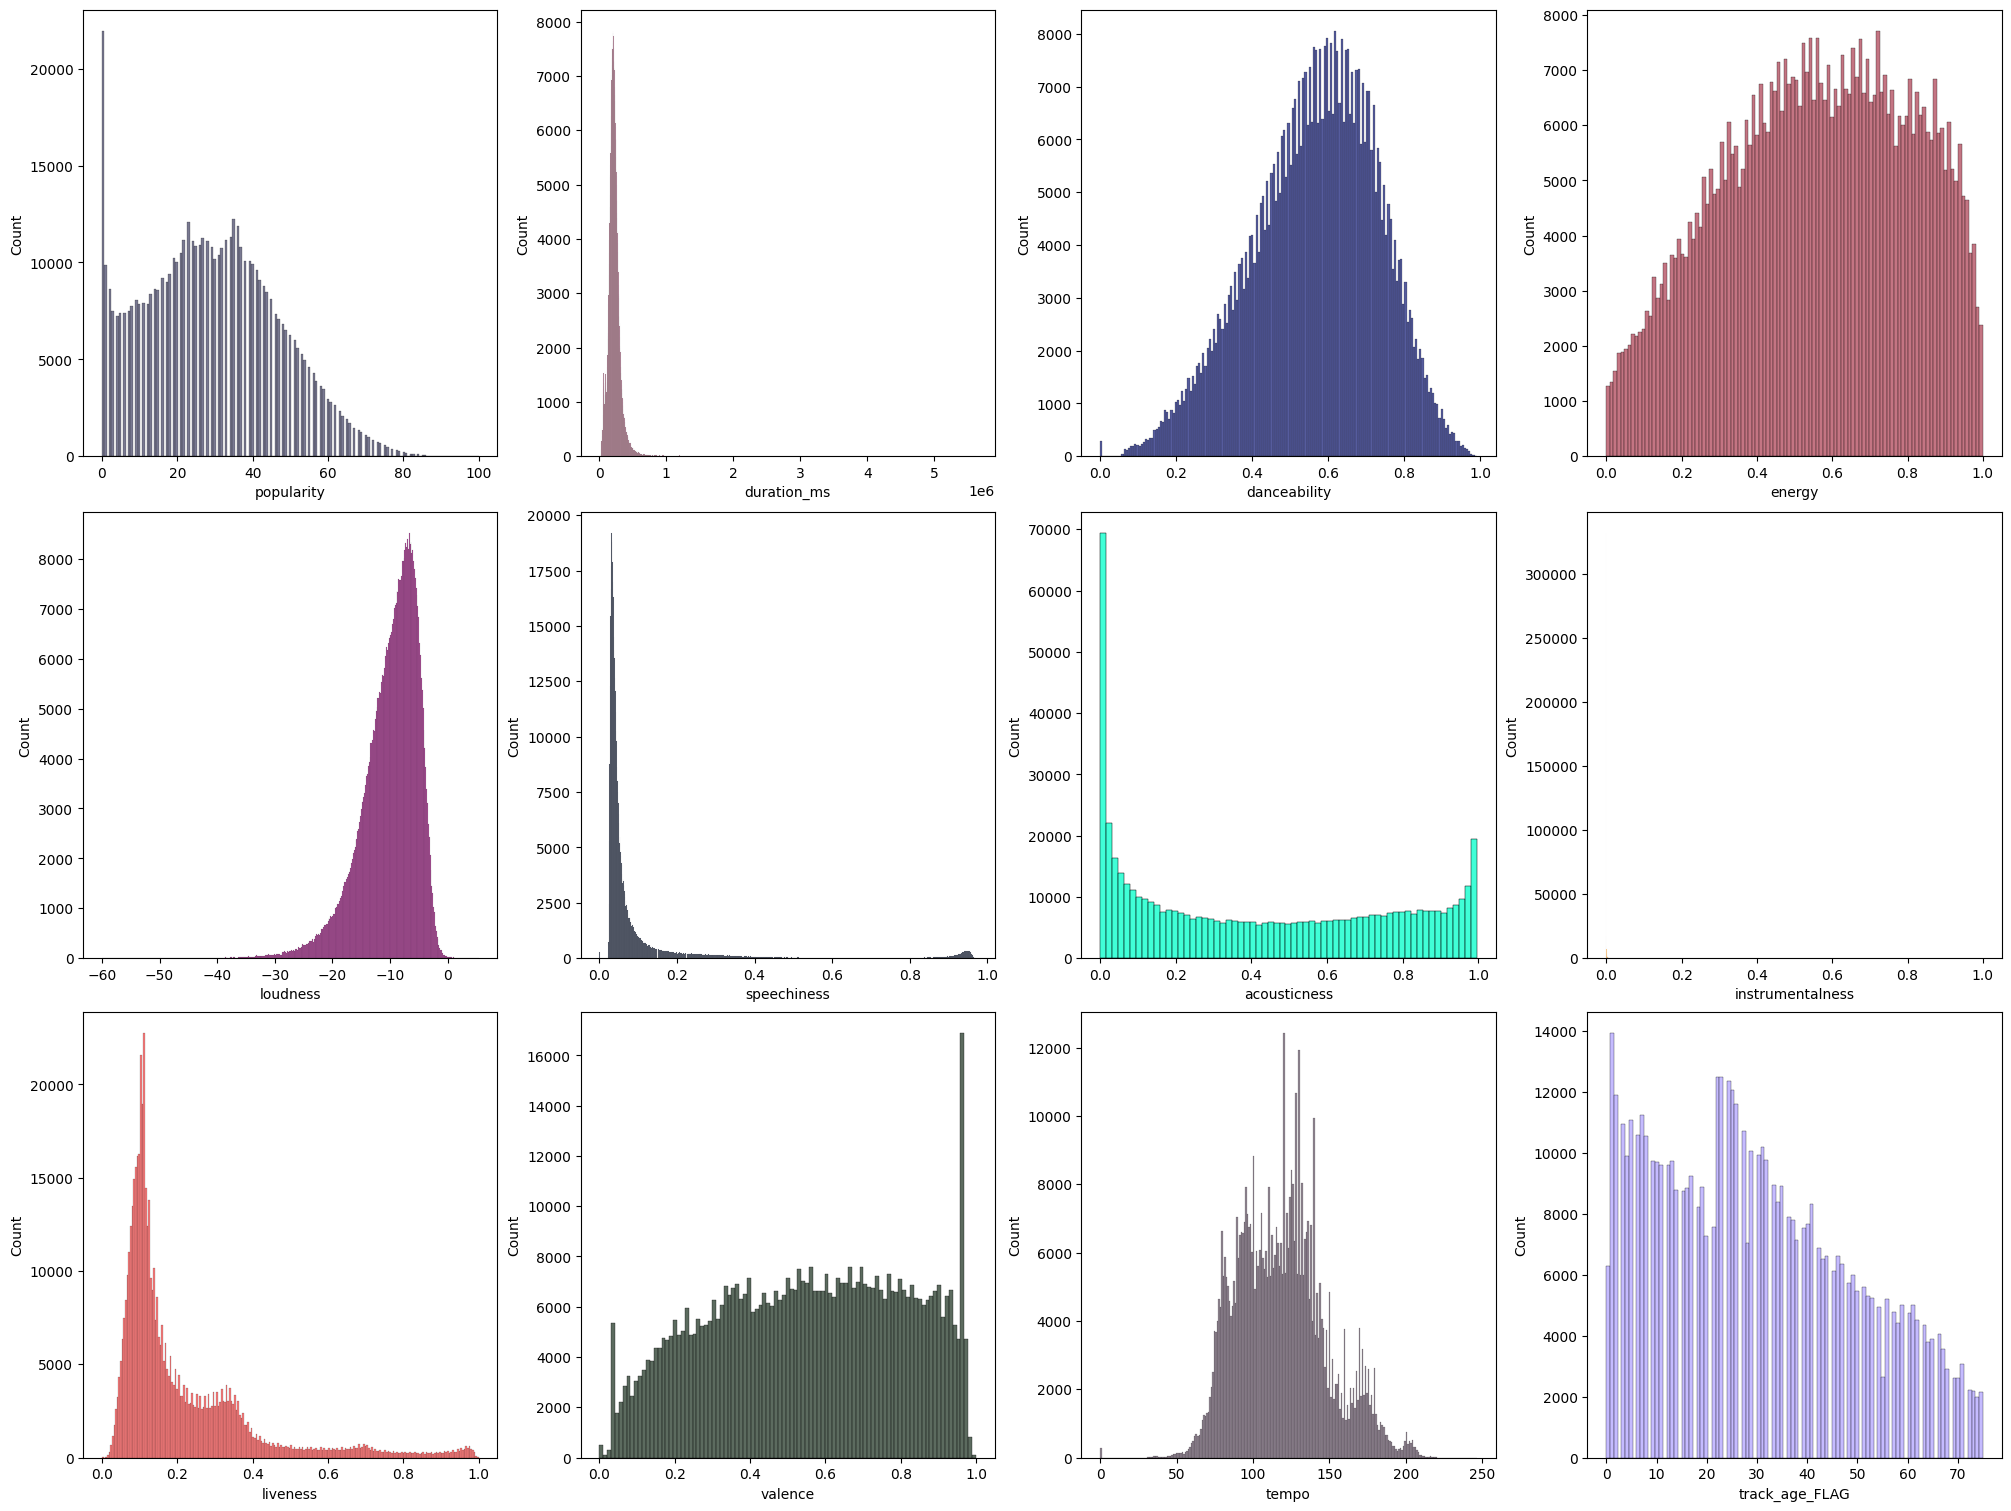

In [24]:
fig, axs = plt.subplots(nrows=3, ncols=4, constrained_layout=True, figsize=(20,15))
sns.histplot(ax=axs[0][0],x=df["popularity"],color="#4C4C6D")
sns.histplot(ax=axs[0][1],x=df["duration_ms"],color="#99627A")
sns.histplot(ax=axs[0][2],x=df["danceability"],color="#1D267D")
sns.histplot(ax=axs[0][3],x=df["energy"],color="#B04759")
sns.histplot(ax=axs[1][0],x=df["loudness"],color="#8B1874")
sns.histplot(ax=axs[1][1],x=df["speechiness"],color="#212A3E")
sns.histplot(ax=axs[1][2],x=df["acousticness"],color="#00FFCA")
sns.histplot(ax=axs[1][3],x=df["instrumentalness"],color="#F6BA6F")
sns.histplot(ax=axs[2][0],x=df["liveness"],color="#F45050")
sns.histplot(ax=axs[2][1],x=df["valence"],color="#263A29")
sns.histplot(ax=axs[2][2],x=df["tempo"],color="#6D5D6E")
sns.histplot(ax=axs[2][3],x=df["track_age_FLAG"],color="#B2A4FF")
plt.show()

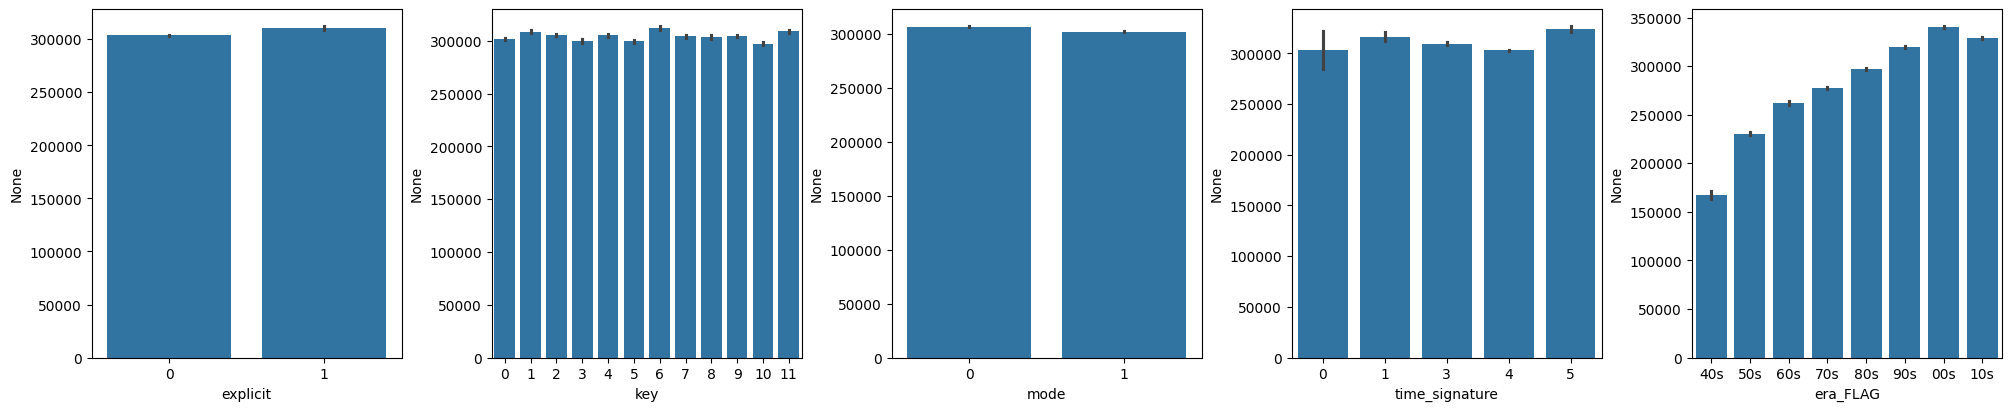

In [25]:
fig, axs = plt.subplots(nrows=1, ncols=5, constrained_layout=True, figsize=(20,4))
sns.barplot(ax=axs[0],x=df["explicit"],y=df["explicit"].index)
sns.barplot(ax=axs[1],x=df["key"],y=df["key"].index)
sns.barplot(ax=axs[2],x=df["mode"],y=df["mode"].index)
sns.barplot(ax=axs[3],x=df["time_signature"],y=df["time_signature"].index)
sns.barplot(ax=axs[4],x=df["era_FLAG"],y=df["era_FLAG"].index)
plt.show();

In [50]:
fig = px.histogram(df, x=df["key"])
fig.show()

In [26]:
df.head()

id  \
19549  6KpMB0Wgw1NVFqwn0DCprf   
19550  2DMWqdcuYP9YbzAscFsolI   
19551  44X3wBWJkqZucNHbYU6Wk9   
19552  5heiTautAti5rDVU1OhneA   
19553  0qkp5UK0HUwmsRfL8MICXK   

                                                    name  popularity  \
19549                                            Manteca          40   
19550           Nocturnes, Op. 27: No. 2 in D-Flat Major          38   
19551                                     Kentucky Waltz          36   
19552  There's No Business Like Show Business - From ...          32   
19553                                   Blue Yodel No. 4          31   

       duration_ms  explicit  \
19549       186693         0   
19550       367827         0   
19551       166160         0   
19552       191293         0   
19553       208067         0   

                                                 artists  \
19549                                ['Dizzy Gillespie']   
19550           ['Frédéric Chopin', 'Arthur Rubinstein']   
19551                                    ['Bill Monroe']   
19552  ['Ethel Merman', 'Ray Middleton', "William O'N...   
19553              ['Bill Monroe & His Blue Grass Boys']   

                                              id_artists  release_date  \
19549                         ['5RzjqfPS0Bu4bUMkyNNDpn']          1946   
19550  ['7y97mc3bZRFXzT2szRM4L4', '5N1GUHhFMRFFgMTjSO...          1946   
19551                         ['5CWbfANRpZbnxdstzcNg5H']          1946   
19552  ['4Kgu9tJgtNXTWMjefKahs9', '3pfx5bZJcVL2dC9xye...          1946   
19553                         ['64vAECmFoB6mi7n1zTRwR8']          1946   

       danceability  energy  ...  mode  speechiness  acousticness  \
19549         0.616  0.6700  ...     0       0.2440         0.829   
19550         0.288  0.0209  ...     1       0.0401         0.992   
19551         0.568  0.1960  ...     1       0.0325         0.866   
19552         0.668  0.2910  ...     1       0.0718         0.968   
19553         0.736  0.2890  ...     1       0.0407         0.970   

       instrumentalness  liveness  valence    tempo  time_signature  \
19549             0.850     0.106   0.5520   87.096               4   
19550             0.914     0.123   0.0427   76.916               3   
19551             0.129     0.229   0.5650  123.302               3   
19552             0.000     0.187   0.6850  135.245               4   
19553             0.368     0.246   0.7860   96.594               4   

       track_age_FLAG  era_FLAG  
19549              75       40s  
19550              75       40s  
19551              75       40s  
19552              75       40s  
19553              75       40s  

[5 rows x 22 columns]

In [27]:
df_model = df.drop(cat_but_car,axis=1)

In [28]:
df_model.head()

popularity  duration_ms  explicit  release_date  danceability  energy  \
19549          40       186693         0          1946         0.616  0.6700   
19550          38       367827         0          1946         0.288  0.0209   
19551          36       166160         0          1946         0.568  0.1960   
19552          32       191293         0          1946         0.668  0.2910   
19553          31       208067         0          1946         0.736  0.2890   

       key  loudness  mode  speechiness  acousticness  instrumentalness  \
19549    5    -8.714     0       0.2440         0.829             0.850   
19550    1   -26.683     1       0.0401         0.992             0.914   
19551    2   -13.042     1       0.0325         0.866             0.129   
19552    1   -11.906     1       0.0718         0.968             0.000   
19553    5   -14.591     1       0.0407         0.970             0.368   

       liveness  valence    tempo  time_signature  track_age_FLAG era_FLAG  
19549     0.106   0.5520   87.096               4              75      40s  
19550     0.123   0.0427   76.916               3              75      40s  
19551     0.229   0.5650  123.302               3              75      40s  
19552     0.187   0.6850  135.245               4              75      40s  
19553     0.246   0.7860   96.594               4              75      40s

In [29]:
df_model=df_model.drop(["release_date","era_FLAG"],axis=1)

In [30]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [31]:
ohe_cols = ["key","explicit","mode","time_signature"]
df_model=one_hot_encoder(df_model,ohe_cols,drop_first=True)

In [32]:
df_model

popularity  duration_ms  danceability  energy  loudness  speechiness  \
19549           40       186693         0.616  0.6700    -8.714       0.2440   
19550           38       367827         0.288  0.0209   -26.683       0.0401   
19551           36       166160         0.568  0.1960   -13.042       0.0325   
19552           32       191293         0.668  0.2910   -11.906       0.0718   
19553           31       208067         0.736  0.2890   -14.591       0.0407   
...            ...          ...           ...     ...       ...          ...   
586667          50       258267         0.560  0.5180    -7.471       0.0292   
586668          72       153293         0.765  0.6630    -5.223       0.0652   
586669          70       187601         0.535  0.3140   -12.823       0.0408   
586670          58       142003         0.696  0.6150    -6.212       0.0345   
586671          38       214360         0.686  0.7230    -7.067       0.0363   

        acousticness  instrumentalness  liveness  valence  ...  key_8  key_9  \
19549          0.829          0.850000    0.1060   0.5520  ...  False  False   
19550          0.992          0.914000    0.1230   0.0427  ...  False  False   
19551          0.866          0.129000    0.2290   0.5650  ...  False  False   
19552          0.968          0.000000    0.1870   0.6850  ...  False  False   
19553          0.970          0.368000    0.2460   0.7860  ...  False  False   
...              ...               ...       ...      ...  ...    ...    ...   
586667         0.785          0.000000    0.0648   0.2110  ...  False  False   
586668         0.141          0.000297    0.0924   0.6860  ...  False  False   
586669         0.895          0.000150    0.0874   0.0663  ...  False  False   
586670         0.206          0.000003    0.3050   0.4380  ...  False  False   
586671         0.105          0.000000    0.2640   0.9750  ...  False  False   

        key_10  key_11  explicit_1  mode_1  time_signature_1  \
19549    False   False       False   False             False   
19550    False   False       False    True             False   
19551    False   False       False    True             False   
19552    False   False       False    True             False   
19553    False   False       False    True             False   
...        ...     ...         ...     ...               ...   
586667   False   False       False   False             False   
586668   False   False       False    True             False   
586669   False   False       False   False             False   
586670    True   False       False    True             False   
586671   False   False       False    True             False   

        time_signature_3  time_signature_4  time_signature_5  
19549              False              True             False  
19550               True             False             False  
19551               True             False             False  
19552              False              True             False  
19553              False              True             False  
...                  ...               ...               ...  
586667             False              True             False  
586668             False              True             False  
586669             False              True             False  
586670             False              True             False  
586671             False              True             False  

[556464 rows x 29 columns]

In [35]:
cat_cols_model, num_cols_model, cat_but_car_model=grab_col_names(df_model)

In [36]:
scaler = StandardScaler()
df_model[num_cols_model] = scaler.fit_transform(df_model[num_cols_model])

In [37]:
df_model

popularity  duration_ms  danceability    energy  loudness  \
19549     0.620055    -0.357479      0.309841  0.460492  0.259504   
19550     0.507554     1.087348     -1.666776 -2.153823 -3.354365   
19551     0.395053    -0.521262      0.020580 -1.448590 -0.610930   
19552     0.170050    -0.320787      0.623208 -1.065968 -0.382461   
19553     0.113799    -0.186988      1.032994 -1.074023 -0.922460   
...            ...          ...           ...       ...       ...   
586667    1.182562     0.213436     -0.027630 -0.151703  0.509492   
586668    2.420078    -0.623897      1.207756  0.432299  0.961603   
586669    2.307576    -0.350236     -0.178287 -0.973333 -0.566885   
586670    1.632568    -0.713952      0.791943  0.238974  0.762698   
586671    0.507554    -0.136792      0.731681  0.673955  0.590743   

        speechiness  acousticness  instrumentalness  liveness   valence  ...  \
19549      0.842632      1.186588          2.945954 -0.581326  0.001557  ...   
19550     -0.352989      1.666586          3.197967 -0.489801 -1.970884  ...   
19551     -0.397553      1.295544          0.106875  0.080879  0.051904  ...   
19552     -0.167108      1.595911         -0.401088 -0.145240  0.516645  ...   
19553     -0.349471      1.601801          1.047984  0.172403  0.907803  ...   
...             ...           ...               ...       ...       ...  ...   
586667    -0.416904      1.057017         -0.401088 -0.803137 -1.319084  ...   
586668    -0.205808     -0.839417         -0.399919 -0.654545  0.520518  ...   
586669    -0.348884      1.380943         -0.400498 -0.681464 -1.879485  ...   
586670    -0.385826     -0.648007         -0.401078  0.490046 -0.439948  ...   
586671    -0.375271     -0.945429         -0.401088  0.269311  1.639771  ...   

        key_8  key_9  key_10  key_11  explicit_1  mode_1  time_signature_1  \
19549   False  False   False   False       False   False             False   
19550   False  False   False   False       False    True             False   
19551   False  False   False   False       False    True             False   
19552   False  False   False   False       False    True             False   
19553   False  False   False   False       False    True             False   
...       ...    ...     ...     ...         ...     ...               ...   
586667  False  False   False   False       False   False             False   
586668  False  False   False   False       False    True             False   
586669  False  False   False   False       False   False             False   
586670  False  False    True   False       False    True             False   
586671  False  False   False   False       False    True             False   

        time_signature_3  time_signature_4  time_signature_5  
19549              False              True             False  
19550               True             False             False  
19551               True             False             False  
19552              False              True             False  
19553              False              True             False  
...                  ...               ...               ...  
586667             False              True             False  
586668             False              True             False  
586669             False              True             False  
586670             False              True             False  
586671             False              True             False  

[556464 rows x 29 columns]

In [45]:
kmeans = KMeans(n_clusters=5, random_state=17).fit(df_model)
kmeans.get_params()

{'algorithm': 'lloyd',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 5,
 'n_init': 'warn',
 'random_state': 17,
 'tol': 0.0001,
 'verbose': 0}

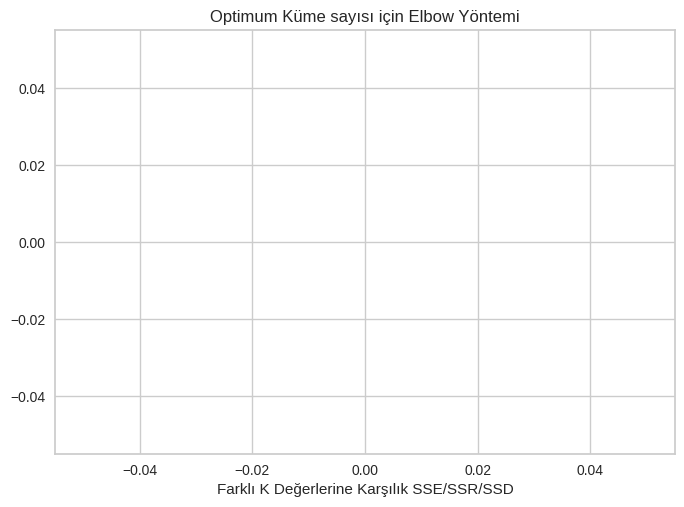

In [46]:
kmeans = KMeans()
ssd = []
K = range(1, 0)

for k in K:
    kmeans = KMeans(n_clusters=k).fit(df_model)
    ssd.append(kmeans.inertia_)

plt.plot(K, ssd, "bx-")
plt.xlabel("Farklı K Değerlerine Karşılık SSE/SSR/SSD")
plt.title("Optimum Küme sayısı için Elbow Yöntemi")
plt.show(block=True)

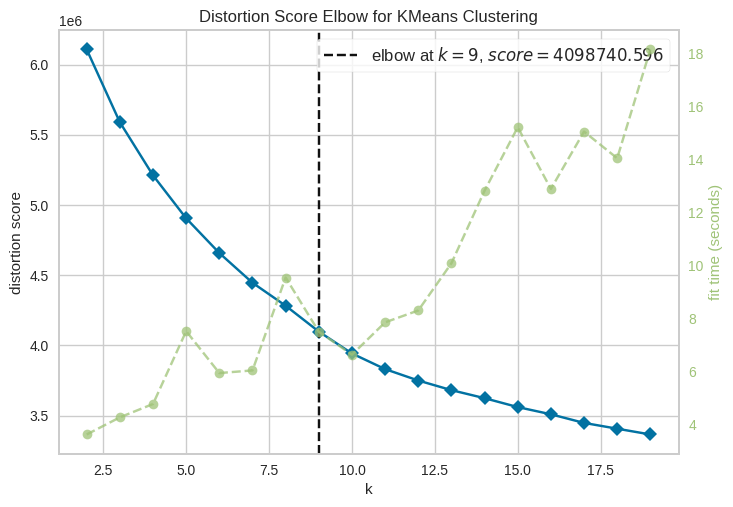

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [42]:
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(2, 20))
elbow.fit(df_model)
elbow.show()

In [43]:
elbow.elbow_value_

9